# Linear Regression mit Kategorischen Features - Code

In diesem Notebook schauen wir uns an, wie wir mit `Kategorischen Features` umgehen am Beispiel der `Linearen Regression`.

## Setup

Setup Code muss *nicht* verstanden werden.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

In [8]:
df = pd.read_csv('data/fish.csv')[['Width', 'Weight', 'Species']].rename(columns={
    'Width': 'width (cm)',
    'Weight': 'weight (g)',
    'Species': 'species'
})

In [9]:
palette={s: c for s, c in zip(df['species'].unique(), sns.color_palette())}

In [10]:
def plot_data(ax, data, x, y):
    sns.scatterplot(data=data, x='width (cm)', y=y, ax=ax, hue='species', palette=palette)
    ax.set_xlim(0, data['width (cm)'].max() + 1)
    ax.set_ylim(0, data[y].max() + 500)

def plot_model_oe(ax, data, x, y, lr_oe, oe):
    plot_data(ax, data, x, y)
    for category in oe.categories_[0]:
        x = np.arange(0, 8, 0.1)
        temp = pd.DataFrame({'width (cm)': x})
        temp['species_ordinal_encoded'] = oe.transform([[category]])[0][0]
        sns.lineplot(x=x, y=lr_oe.predict(temp), ax=ax, color=palette[category])

def plot_model_ohe(ax, data, x, y, lr_ohe, ohe):
    plot_data(ax, data, x, y)
    for category in ohe.categories_[0]:
        x = np.arange(0, 8, 0.1)
        temp = pd.DataFrame({'width (cm)': x})
        for c in ohe.categories_[0]:
            temp[c] = 1 if category == c else 0
        sns.lineplot(x=x, y=lr_ohe.predict(temp), ax=ax, color=palette[category])


## Baseline

Zuerst erstellen wir eine Baseline, die ohne das Feature `specie` arbeitet.
Ein Modell mit dem Feature `specie` sollte die Baseline natürlich schlagen.

In [11]:
baseline_lr = LinearRegression()  # Erstellen vom Modell

baseline_lr.fit(X=df[['width (cm)']], y=df['weight (g)'])  # Modell lernt (Lernphase)
y_hat = baseline_lr.predict(df[['width (cm)']])
baseline_performance = round(mean_squared_error(df['weight (g)'], y_hat))
print("Baseline Performanz:", baseline_performance)

Baseline Performanz: 27265


## Warum Ordinal-Encoder hier nicht funktioniert

### OrdinalEncoder

In [12]:
from sklearn.preprocessing import OrdinalEncoder

df_oe = df.copy()

oe = OrdinalEncoder()
df_oe['species_ordinal_encoded']  = oe.fit_transform(df_oe[['species']].values)
display(df_oe[['species', 'species_ordinal_encoded']].sample(10))

,species,species_ordinal_encoded
52,Roach,4.0
51,Roach,4.0
36,Roach,4.0
125,Perch,2.0
63,Parkki,1.0
19,Bream,0.0
46,Roach,4.0
68,Parkki,1.0
34,Bream,0.0
83,Perch,2.0


In [13]:
lr_oe = LinearRegression()

lr_oe.fit(X=df_oe[['width (cm)', 'species_ordinal_encoded']], y=df_oe['weight (g)'])
y_hat = lr_oe.predict(df_oe[['width (cm)', 'species_ordinal_encoded']])
oe_performance = round(mean_squared_error(df['weight (g)'], y_hat))
print("OrdinalEncoder Performanz: ", oe_performance)

OrdinalEncoder Performanz:  27029


In [14]:
print(lr_oe.intercept_, lr_oe.coef_)

-473.0641280751862 [192.20899737   9.85361763]


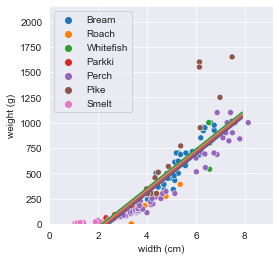

In [15]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_model_oe(ax, df_oe, 'width (cm)', 'weight (g)', lr_oe, oe)
plt.show()

## One-Hot-Encoder

In [16]:
from sklearn.preprocessing import OneHotEncoder

df_ohe = df.copy()

ohe = OneHotEncoder()
X_ohe_species = ohe.fit_transform(df_ohe[['species']])
X_species = pd.DataFrame(data=X_ohe_species.toarray(), index=df_ohe.index, columns=ohe.categories_[0])

df_ohe = pd.concat([df_ohe, X_species], axis=1)

display(df_ohe[['species', *ohe.categories_[0]]].sample(10))

,species,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
122,Perch,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20,Bream,1.0,0.0,0.0,0.0,0.0,0.0,0.0
82,Perch,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49,Roach,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,Bream,1.0,0.0,0.0,0.0,0.0,0.0,0.0
126,Perch,0.0,0.0,1.0,0.0,0.0,0.0,0.0
129,Pike,0.0,0.0,0.0,1.0,0.0,0.0,0.0
26,Bream,1.0,0.0,0.0,0.0,0.0,0.0,0.0
65,Parkki,0.0,1.0,0.0,0.0,0.0,0.0,0.0
85,Perch,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Die gelernten $\vec{\beta}$ können wir aus der `Linearen Regression` wie folgt beziehen:

In [17]:
lr_ohe = LinearRegression()  # Erstellen vom Modell

lr_ohe.fit(X=df_ohe[['width (cm)', *ohe.categories_[0]]], y=df_ohe['weight (g)'])  # Modell lernt (Lernphase)
y_hat = lr_ohe.predict(df_ohe[['width (cm)', *ohe.categories_[0]]])
ohe_performance = round(mean_squared_error(df['weight (g)'], y_hat))
print("One-Hot-Encoder Performanz: ", ohe_performance)

One-Hot-Encoder Performanz:  15422


In [18]:
print(lr_ohe.intercept_, lr_ohe.coef_)

-501.7256452120844 [ 210.00330566  -20.26272523  -19.821456   -112.65263184  152.27441958
 -114.38494641  231.48028674 -116.63294685]


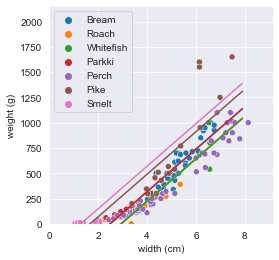

In [19]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_model_ohe(ax, df_ohe, 'width (cm)', 'weight (g)', lr_ohe, ohe)
plt.show()

## Conclusion

In [20]:
print("Baseline Performanz:                                 ", baseline_performance)
print("OrdinalEncoder Performanz:                           ", oe_performance)
print("One-Hot-Encoder Performanz:                          ", ohe_performance)

Baseline Performanz:                                  27265
OrdinalEncoder Performanz:                            27029
One-Hot-Encoder Performanz:                           15422
